### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
from glob import glob 
from os.path import join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", context='paper', color_codes=False)

from plotGraphs import *
from MLpipelines.plotResults import *
from imagen_dataloader import *
# from niwidgets import NiftiWidget

In [3]:
sys.path.insert(0, 'posthoc_analysis/')
from imagen_SA import *

In [4]:
# Specify the path to the data
DATA_DIR = "/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/"
BIDS_DIR = "/ritter/share/data/IMAGEN/IMAGEN_BIDS/"

In [5]:
# path to questionaires files
qs = dict(
        AUDIT_BL  = DATA_DIR + "BL/psytools/IMAGEN-IMGN_AUDIT_CHILD_RC5-IMAGEN_DIGEST.csv",
        AUDIT_FU1 = DATA_DIR + "FU1/psytools/IMAGEN-IMGN_AUDIT_CHILD_FU_RC5-IMAGEN_DIGEST.csv",
        AUDIT_FU2 = DATA_DIR + "FU2/psytools/IMAGEN-IMGN_AUDIT_CHILD_FU2-IMAGEN_DIGEST.csv",
        AUDIT_FU3 = DATA_DIR + "FU3/psytools/IMAGEN-IMGN_AUDIT_FU3.csv",
        ESPAD_BL  = DATA_DIR + "BL/psytools/IMAGEN-IMGN_ESPAD_CHILD_RC5-IMAGEN_DIGEST.csv",
        ESPAD_FU1 = DATA_DIR + "FU1/psytools/IMAGEN-IMGN_ESPAD_CHILD_FU_RC5-IMAGEN_DIGEST.csv",
        ESPAD_FU2 = DATA_DIR + "FU2/psytools/IMAGEN-IMGN_ESPAD_CHILD_FU2-IMAGEN_DIGEST.csv",
        ESPAD_FU3 = DATA_DIR + "FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv",
          
        AUDIT_GM       = DATA_DIR + "growthcurves/AUDIT/IMGN_AUDITtotal_GM.csv",
        AUDIT_GM_FINE  = DATA_DIR + "growthcurves/AUDIT/IMGN_AUDITtotal_GM_FINE.csv",
        ESPAD_GM       = DATA_DIR + "growthcurves/ESPAD/IMGN_ESPAD19b_GM.csv",
        ESPAD_GM_FINE  = DATA_DIR + "growthcurves/ESPAD/IMGN_ESPAD19b_GM_FINE.csv",
        
        PHENOTYPE = DATA_DIR + "combinations/drinking_phenotype/Seo_drinking_phenotype_fu2.csv",
        )

### Data:

In [131]:
df_demo = pd.read_csv(join(DATA_DIR, "FU3/participants/IMAGEN_demographics.csv"), dtype={"PSC2":int})
df_demo = df_demo.rename(columns={"PSC2" : "ID", "recruitment centre":"site"})
df_demo2 = pd.read_csv(join(DATA_DIR, "IMAGEN_stats_from_db.csv"), sep=";", dtype={"code_in_study":int})
df_demo2 = df_demo2.rename(columns={"code_in_study" : "ID"})[["ID", "gender", "handedness"]]
df_demo = pd.merge(df_demo, df_demo2, on='ID', how="inner")

test_ids = df_demo.loc[df_demo["site"]=="NOTTINGHAM", "ID"]

print("Total subjects in demographics table =", len(df_demo))
print("Total subjects set aside as test set =", len(test_ids))
del df_demo2

Total subjects in demographics table = 2315
Total subjects set aside as test set = 375


In [132]:
dataset = Imagen()
# dataset.df.info()

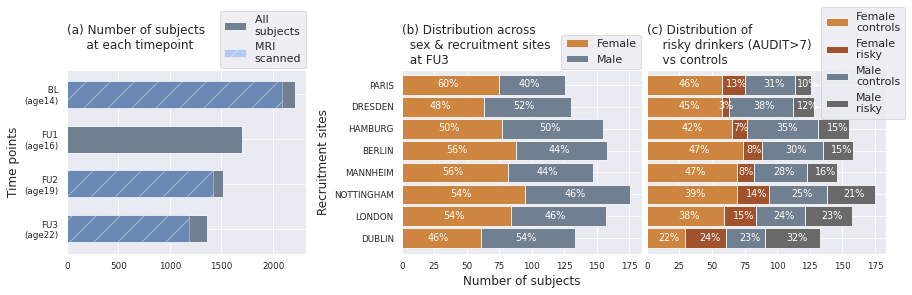

In [118]:
from matplotlib.colors import ListedColormap

fontsize = 12
f,axes = plt.subplots(1,3, figsize=(14,4.5))

##### PLOT 1 #############################################################################################
axis = axes[0]

# first plot the total count
all_counts = pd.Series({"FU3\n(age22)":1359, "FU2\n(age19)":1514, 
                        "FU1\n(age16)":1699, " BL\n(age14)":2213}
                       , name="All \nsubjects")
all_counts.plot.barh(ax=axis, width=0.6, color = 'slategray')

# then plot the MRI scans as overlay
df = pd.concat([dataset.df, dataset.df_holdout])
df_temp = df.filter(regex=("(path_T1w)")).notnull().sum().unstack()
# add the missing 'FU1' as a dummy row with 0 count
df_temp.loc['FU1','path_T1w'] = 0
df_temp.index = df_temp.index.map({
                                    "FU3":"FU3\n(age22)",
                                    "FU2":"FU2\n(age19)",
                                    "FU1":"FU1\n(age16)",
                                    "BL" :" BL\n(age14)",
                                })
df_temp = df_temp.rename(columns={"path_T1w":"MRI \nscanned"})#, "path_FAsk_DTI":"with DTI data"})
df_temp.sort_index(ascending=False).plot.barh(ax=axis, width=0.6,
                                              color='cornflowerblue', hatch="/", alpha=0.4)
axis.set_title("(a) Number of subjects \n     at each timepoint \n", loc='left', fontsize=fontsize)
# axis.set_xlabel('Number of subjects', fontsize=fontsize)
axis.set_ylabel('Time points', fontsize=fontsize)
axis.legend(fontsize=fontsize-1, loc='upper right', bbox_to_anchor=(1.02,1.35))

##### PLOT 2 ##############################################################################################
valid_subs = df["FU3"]["path_T1w"].dropna().index

##calculate df_audit first for the sort order 
df_audit = pd.read_csv(qs['AUDIT_FU3'], usecols=["audit_abuse_flag", "User code"], dtype={"User code":str})
df_audit["User code"] = df_audit["User code"].apply(lambda x: int(x.replace("-C", "")))
df_audit = df_audit.rename(columns={"User code" : "ID"})
df_audit = df_audit.merge(df_demo[["ID", "sex", "site"]], on="ID")
df_audit = df_audit[df_audit.ID.isin(valid_subs)] 
df_audit = df_audit[["sex", "audit_abuse_flag", "site"]].value_counts().unstack().T
# sort by ratio of alcohol_risk_females / alcohol_risk_males
sort_order = (df_audit[('M', 1)]/df_audit[('M', 0)]).sort_values(ascending=False).index
# select the colors for the area
colors = ['peru', 'sienna',  'slategrey', 'dimgrey'] #'peachpuff', 'lightskyblue',
labels = ['Female\ncontrols', 'Female\nrisky', 'Male\ncontrols', 'Male\nrisky']

axis = axes[1]
df_temp = df["FU3"].loc[valid_subs, ["sex", "site"]].value_counts().unstack().T
# sort by total subjects
df_temp = df_temp.loc[sort_order]

df_temp = df_temp.rename(columns={"F":"Female", "M":"Male"})
df_temp.plot.barh(
    stacked=True, ax=axis, width=0.9, 
    color=[colors[0], colors[2]]
)
axis.set_title("(b) Distribution across \n  sex & recruitment sites \n  at FU3", loc='left', fontsize=fontsize)
axis.set_ylabel('Recruitment sites', fontsize=fontsize)
axis.set_xlabel('Number of subjects', fontsize=fontsize)
axis.legend(fontsize=fontsize-1, loc='upper right', bbox_to_anchor=(1.02,1.22))

# display(df_temp)
# add the percetage as a text on the bar plot
for i, (site, row) in enumerate(df_temp.iterrows()):
    axis.text(row['Female']//2-10, i-.1, "{}%".format(round(row['Female']*100/row.sum())), color='white')
    axis.text(row['Female']+row['Male']//2-10, i-.1, "{}%".format(round(row['Male']*100/row.sum())), color='white')
    
axis = axes[2]

df_audit = df_audit.loc[sort_order]
# display(df_audit)
df_audit.plot.barh(stacked=True, ax=axis, width=0.9, color=colors)

# add the percetage as a text on the bar plot
for i, (site, row) in enumerate(df_audit.iterrows()):
    axis.text(row['F'][0]//2-5, i-.1, "{}%".format(round(row['F'][0]*100/row.sum())), color='white')
    axis.text(row['F'][0]+row['F'][1]//2-5, i-.1, "{}%".format(row['F'][1]*100//row.sum()), color='white')
    axis.text(row['F'].sum()+row['M'][0]//2-5, i-.1, "{}%".format(round(row['M'][0]*100/row.sum())), color='white')
    axis.text(row['F'].sum()+row['M'][0]+row['M'][1]//2-5, i-.1, "{}%".format(round(row['M'][1]*100/row.sum())), color='white')
    
# axis.set_xlim(0)
axis.set_yticklabels([])
axis.set_ylabel('')
# axis.set_xlabel('Number of subjects', fontsize=fontsize)
axis.legend(labels=labels, fontsize=fontsize-1, loc='upper right', bbox_to_anchor=(1.1,1.37))
axis.set_title("(c) Distribution of \n    risky drinkers (AUDIT>7)\n    vs controls", loc='left', fontsize=fontsize)

plt.tight_layout()
pos = axis.get_position()
pos_pt = pos.get_points()
move_by = pos_pt[0][0] - axes[1].get_position().get_points()[1][0]
pos_pt[:,0] -= move_by - 0.005
pos.set_points(pos_pt)
axis.set_position(pos)

f.savefig("figures/imagen_stats.pdf", format='pdf', bbox_inches='tight', pad_inches=0)

In [19]:
len(valid_subs)

1182

### Method: confound control

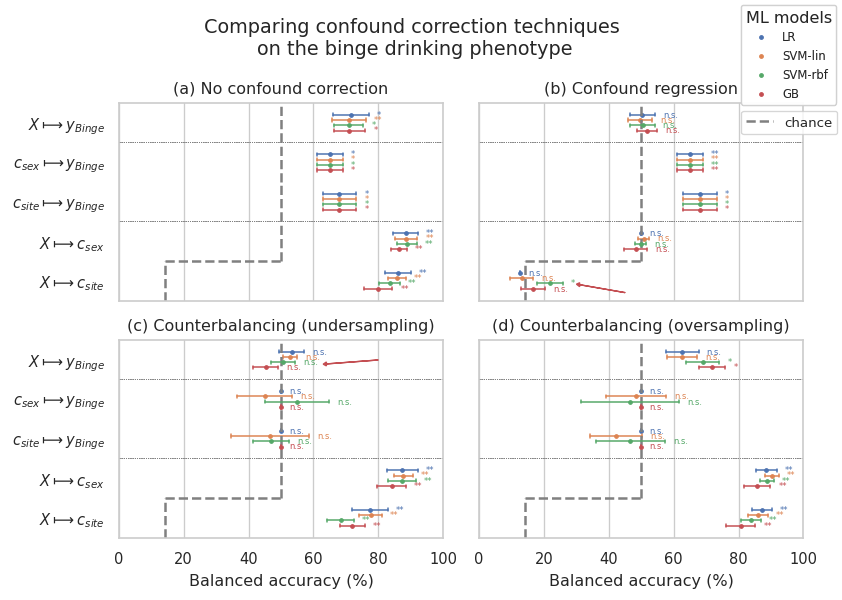

In [129]:
df = pd.read_csv(sorted(glob(f"MLpipelines/results/conf_ctrl/*/run.csv"))[-1])  #audit-combos*audit-c*22

x="test_score"
conf_ctrl=["baseline", "cr", "under-cb", "over-cb"]
conf_ctrl_rename={"baseline":"(a) No confound correction", "cr":"(b) Confound regression", 
                  "under-cb":"(c) Counterbalancing (undersampling)", "over-cb":"(d) Counterbalancing (oversampling)"}
input_type='' #'sMRI (22yrs)'
no_confs=False
sorty_by=None
join=False
    
input_types_cnt = 0
df = df.assign(i_type=input_type)

# drop confound-related predictions if requested
if "i_is_conf" in df.columns and no_confs: 
    df = df[~(df.i_is_conf) & ~(df.o_is_conf)]

# calculate p_values if permutation tests were run
if f"permuted_{x}" in df.columns:
    df = calc_p_values(df, x, viz=False)
#     plt.show()
# if conf_ctrl is not configured then automatically determine it
if not conf_ctrl: 
    conf_ctrl = df["technique"].unique()
else:
    df = df[df["technique"].isin(conf_ctrl)]

# if the x metric is not in the results, then try to compute this metric from sklearn.metrics
if x not in df.columns:
    df = compute_metric(df, x)

# make io labels readable with latex formating
df.loc[:,"io"] = df.apply(remap_io, axis=1)      

# setup the figure properties
sns.set(style='whitegrid', context='paper')
fig, axes = plt.subplots(2, len(conf_ctrl)//2, 
                         sharex=True, sharey=True, 
                         dpi=120, figsize=(7,5))
axes = axes.ravel()
plt.xlim([0,100])    

y="io"     
y_order = get_y_order(df, y, sorty_by).tolist()
#hacks
df[x] = df[x]*100
y_order = [y_order[2]] + y_order[3:] + y_order[0:2]
df['o'] = df.apply(lambda row: row.o if row.o_is_conf else '', axis=1)

hue_order = [m for m in ["LR", "SVM-lin", "SVM-rbf", "GB"] if m in df["model"].unique()]

for j, (t, ax) in enumerate(zip(conf_ctrl, axes)): 
    dfi = df.query(f"technique == '{t}'")
    # plotting details
    palette = sns.color_palette()
    dodge, scale, errwidth, capsize = 0.4, 0.4, 0.9, 0.08     
    # todo bugfix ci is sensible only if each trial score is statistically independant
    ax = sns.pointplot(y=y, x=x, order=y_order,
                       hue="model", hue_order=hue_order,
                       join=join, data=dfi, ax=ax,
                       ci='sd', errwidth=errwidth, capsize=capsize,
                       dodge=dodge, scale=scale, palette=palette)
#     if j!=len(df["technique"].unique())-1: 
    ax.legend_.remove()
    ax.set_title("{}".format(conf_ctrl_rename[t]))
    ax.set_xlabel("")
    ax.set_ylabel("")
    if j>=(len(conf_ctrl)//2): ax.set_xlabel("Balanced accuracy (%)")

    # Add significance stars if permutation scores are available
    if f"permuted_{x}" in dfi.columns:

        # collect p_values as a dict of form {mean_accuracy: p_value}
        p_dict = {g[x].mean(): g["p_value"].iloc[0] 
                  for i, g in dfi.groupby(["io", "model"])}
        # filter out the error bars from all lines 
        # and store the position of their right edges to print the p_values at 
        err_bars_pos = [(l.get_xdata()[1], l.get_ydata()[0])
                        for l in ax.lines if l.get_ydata()[0]==l.get_ydata()[1]] 
        # also collect the position of the mean 'accuracy' points
        points_pos = [tuple(p_pos)  for c in ax.collections for p_pos in c.get_offsets()]

        for i, pos in enumerate(err_bars_pos):

            p_pos = points_pos[i]
            # check that the y position of both the point and error bar are the same-
            assert p_pos[1] == pos[1], f"y position of mean pt ({p_pos}) and error bar ({pos}) don't match"
            # choose the error bar with the same mean accuracy point
            p =  p_dict[p_pos[0]] 
            ast = return_asterisks(p)

            ax.annotate(ast, np.array(pos) + (2.5, 0.05), 
                        color=palette[i//len(df[y].unique())], fontsize=5)
    
    if t=='cr':
        ax.arrow(45, 4.3, -14, -0.2, head_width=0.1, head_length=1, fc='r', ec='r')
    elif t=='under-cb':
        ax.arrow(80, 0.01, -16, 0.1, head_width=0.1, head_length=1, fc='r', ec='r')
        
    # draw the chance line in the legend
    chance= [50, 50, 50, 50, 100/7][::-1]
    for z, ch in enumerate(chance): 
        ax.axvline(x=ch, ymin=z/len(chance), ymax=(z+1)/(len(chance)), label="chance", c='gray', ls='--', lw=1.5)
    ax.axhline(y=3.5, xmin=1/7,  xmax=0.5, c='gray', ls='--', lw=1.5) #hack
            
    for v in [0.5, 2.5]*len(dfi[y].unique()): 
        ax.axhline(y=v, c='gray', ls=':', lw=0.5)
    
handles, legends = ax.get_legend_handles_labels()
leg1 = fig.legend(handles[len(chance):], legends[len(chance):], loc="upper right", title="ML models", fontsize=7) #
# only choose the first 'chance' legend
import matplotlib.lines as mlines
leg2 = fig.legend([handles[0]], [legends[0]], loc=(0.88, 0.775), fontsize=8)
fig.add_artist(leg1)
plt.suptitle("Comparing confound correction techniques \non the binge drinking phenotype")
plt.tight_layout()
plt.savefig("figures/results_cc.pdf", bbox_inches='tight')

### Results:

#### Exploratory results

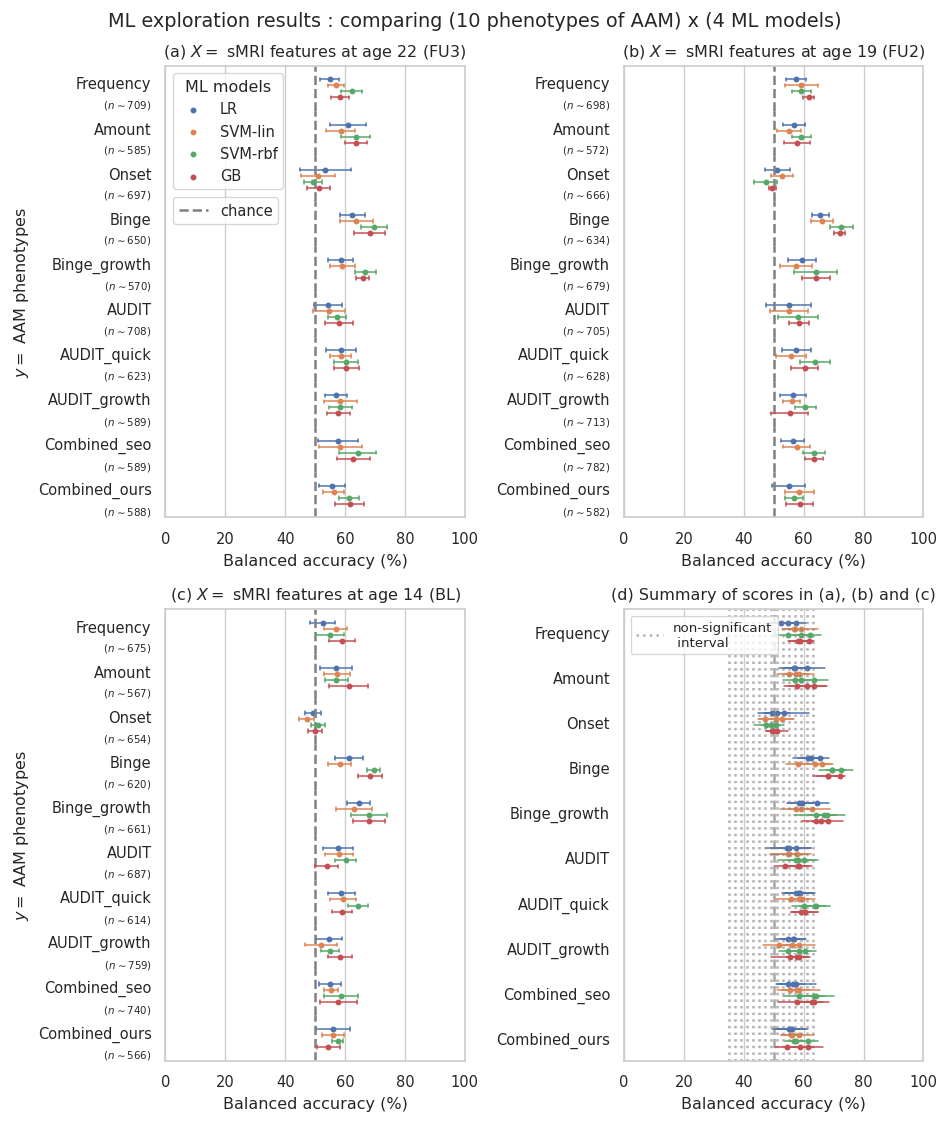

In [7]:
r_path = "newlbls-clean" #"across_sites/lbls"

df_fulls = [
    (r"(a) $X=$ sMRI features at age 22 (FU3)", [pd.read_csv(f) for f in sorted(glob(f"MLpipelines/results/{r_path}-fu3*/*/run.csv"))]),
    (r"(b) $X=$ sMRI features at age 19 (FU2)", [pd.read_csv(f) for f in sorted(glob(f"MLpipelines/results/{r_path}-fu2*/*/run.csv"))]),
    (r"(c) $X=$ sMRI features at age 14 (BL)",  [pd.read_csv(f) for f in sorted(glob(f"MLpipelines/results/{r_path}-bl*/*/run.csv"))]),
]
x = "test_score"  # roc_auc , test_score
conf_ctrl = 'cb'
sorty_by = None #'n_samples'
join = False
n_ios = 10
xlim = [0, 100]
# setup the figure properties
sns.set(style='whitegrid', context='paper')

fig, axes = plt.subplots(2, 2, 
                         sharex=False, sharey=False,  dpi=120, #(x=="test_score")
                         figsize=(4*2, 1.9*(1+0.4*(n_ios))))
summary_ax = axes[1][1]
remaining_axs = [ax for ax in axes.ravel() if (ax != summary_ax)]

df = pd.DataFrame()

# HACK : set the input_sMRI_type as a 'technique' to make the rest of the function work
for t, df_full in df_fulls:
    dfi = pd.concat(df_full)
    # drop confound-related columns
    dfi = dfi[~(dfi.i_is_conf) & ~(dfi.o_is_conf)]
    dfi = dfi[dfi["technique"]==conf_ctrl]
    # calculate p_values if permutation tests were run
    if f"permuted_{x}" in dfi.columns:
        dfi = calc_p_values(dfi, x)
    dfi["technique"] = t
    df = pd.concat([df, dfi])

# fixes
xlabel = "AUC ROC (%)" if (x=="roc_auc") else "Balanced accuracy (%)"
df.loc[df["o"]=="onset<15", "o"]="Onset"
df[x] = df[x]*100

# if the x metric is not in the results, then try to compute this metric from sklearn.metrics
if x not in df.columns:
    df = compute_metric(df, x)
    
####################################################################
    
y="o"     
y_order = ['Frequency','Amount',  'Onset',  'Binge', 'Binge_growth', 
           'AUDIT', 'AUDIT_quick', 'AUDIT_growth', 'Combined_seo','Combined_ours' ]#get_y_order(df, y=y, sorty_by=sorty_by)

for j, ((t, dfi), ax) in enumerate(zip(df.groupby("technique", sort=False), remaining_axs)):   
    # plotting details
    palette = sns.color_palette()
    dodge, scale, errwidth, capsize = 0.4, 0.5, 0.9, 0.08     
    hue_order = ["LR", "SVM-lin", "SVM-rbf", "GB"]
    # todo bugfix ci is sensible only if each trial score is statistically independant
    ax = sns.pointplot(y=y, x=x, order=y_order,
                       hue="model", hue_order=hue_order,
                       join=join, data=dfi, ax=ax,
                       ci='sd', errwidth=errwidth, capsize=capsize,
                       dodge=dodge, scale=scale, palette=palette)
    
    # since sample_size are different for different io (i.e. they are from different data subsets)
    # add sample_size info in y_label
#     if x!="test_score":
    labels = ax.get_yticklabels()
    for label in labels:
        n_samples = df.loc[(df["o"]==label.get_text())&(df["technique"]==t), "n_samples"].iloc[0]
        new_label = f"{label.get_text()}\n $_[(n\sim{n_samples})]$"
        label.set_text(new_label.replace('[','{').replace(']','}'))
    ax.set_yticklabels(labels)

    ax.set_title(t)
    ax.set_xlim(xlim)
    ax.set_ylabel("")
    if j in [0,2]: ax.set_ylabel(r"$y=$ AAM phenotypes")
    ax.set_xlabel(xlabel)
        
    # Add significance stars if permutation scores are available
    if f"permuted_{x}" in dfi.columns:

        n_y_rows = len(dfi["o"].unique())
        # collect p_values as a dict of form {mean_accuracy: p_value}
        mean_acc, p_vals = zip(*((g[x].mean(), g["p_value"].iloc[0])
                  for i, g in dfi.groupby(["io", "model"])))
        # perform FDR correction
#         print("\nbefore correction:\n", np.array(p_vals))
#         _,p_vals = fdrcorrection(p_vals)
#         print("after correction:\n", p_vals)
        p_dict = dict(zip(mean_acc, p_vals))
        # filter out the error bars from all lines 
        # and store the position of their right edges to print the p_values at 
        err_bars_pos = [(l.get_xdata()[1], l.get_ydata()[0])
                        for l in ax.lines if l.get_ydata()[0]==l.get_ydata()[1]] 
        # also collect the position of the mean 'accuracy' points
        points_pos = [tuple(p_pos)  for c in ax.collections for p_pos in c.get_offsets()]

        for i, pos in enumerate(err_bars_pos):
            p_pos = points_pos[i]
            # check that the y position of both the point and error bar are the same
            assert p_pos[1] == pos[1]
            # choose the error bar with the same mean accuracy point
            p =  p_dict[p_pos[0]] 
            ast = return_asterisks(p)
            ax.annotate(ast, np.array(pos)+(0.02, 0.06), 
                        color=palette[i//n_y_rows], fontsize=5)

    # draw the chance line in the legend
    chance = (len(dfi[y].unique()))*[50] #todo
    for z, ch in enumerate(chance): 
        ax.axvline(x=ch, ymin=z/len(chance), ymax=(z+1)/(len(chance)), 
                   label='chance', c='gray', ls='--', lw=1.5)

    if j==0:#len(df.groupby("technique"))-1:
        # add legend: add models info and chance label to last plot
        handles, legends = ax.get_legend_handles_labels()
        leg1 = ax.legend(handles[len(chance):], legends[len(chance):], loc="upper left", title="ML models")
        # only choose the first 'chance' legend
        leg2 = ax.legend([handles[0]], [legends[0]], fancybox=True, frameon=True, loc=(0.025, 0.65))
        ax.add_artist(leg1)
        
    else:
        ax.legend_.remove()
        
#########################

for j, (t, dfi) in enumerate(df.groupby("technique", sort=False)):   
    ax = sns.pointplot(y=y, x=x, order=y_order,
                       hue="model", hue_order=hue_order,
                       join=join, data=dfi, ax=summary_ax, 
                       ci='sd', errwidth=errwidth, capsize=0,
                       dodge=dodge, scale=scale, palette=palette)

ax.set_title("(d) Summary of scores in (a), (b) and (c)")
ax.set_xlim(xlim)
ax.set_ylabel("")
ax.set_xlabel(xlabel)

color='gray'

ax.axvline(x=50, label='chance', c='gray', ls='--', lw=1.5, alpha=0.7)
insigificance_interval = (32,70) if x=='roc_auc' else (35,65)
for xi in range(*insigificance_interval,2): 
    ax.axvline(x=xi, c=color, ls=':', lw=1.5, alpha=0.6, label='non-significant\n interval')

# create the legend
handles, legends = ax.get_legend_handles_labels()
leg2 = ax.legend([handles[1]], [legends[1]], loc='upper left', fontsize=8)
# if "across_sites" in r_path:
#     plt.suptitle("Exploratory analysis with leave-one-site-out CV (7-folds)")
#     plt.tight_layout()
#     plt.savefig("figures/results_explore_sites{}.pdf".format("_auc" if x=='roc_auc' else ''))
# else:
plt.suptitle("ML exploration results : comparing (10 phenotypes of AAM) x (4 ML models)")
plt.tight_layout()
plt.savefig("figures/results_explore{}.pdf".format("_auc" if x=='roc_auc' else ''), bbox_inches='tight', pad_inches=0.05)

#### Generatization test

['$sMRI_{22yr} \\longmapsto AAM_{22yr}$'
 '$sMRI_{19yr} \\longmapsto AAM_{22yr}$'
 '$sMRI_{14yr} \\longmapsto AAM_{22yr}$']


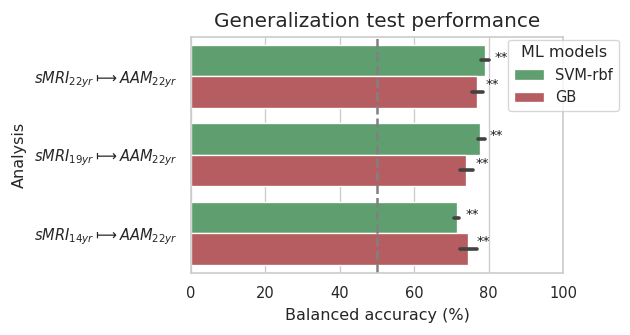

In [11]:
df = pd.read_csv("MLpipelines/results/holdout_all-tp-clean_run.csv")  

BEST_MODELS = ['SVM-rbf', 'GB']
BEST_SCORE_ONLY = False
x='holdout_score'
no_confs=True
join=False
palette = sns.color_palette()[2:]

remap_io_2 = {'$X_{22yr} \\longmapsto y_{Binge}$': '$sMRI_{22yr} \\longmapsto AAM_{22yr}$',
              '$X_{19yr} \\longmapsto y_{Binge}$': '$sMRI_{19yr} \\longmapsto AAM_{22yr}$',
              '$X_{14yr} \\longmapsto y_{Binge}$': '$sMRI_{14yr} \\longmapsto AAM_{22yr}$'}

tp_map = {"bl":"14yr", "fu1":"16yr", "fu2":"19yr", "fu3":"22yr"} 
df["i_type"] = df["tp"].map(tp_map)
input_types_cnt = 3 

# calculate p_values if permutation tests were run
if f"permuted_{x}" in df.columns:
    df = calc_p_values(df, x, viz=False)
    
ios = df["io"].unique() 

# if the x metric is not in the results, then try to compute this metric from sklearn.metrics
if x not in df.columns:
    df = compute_metric(df, x)

# make io labels readable with latex formating
df.loc[:,"io"] = df.apply(remap_io, axis=1) 
df = df.replace({'io':remap_io_2})
df[x] = df[x]*100  

# setup the figure properties
sns.set(style='whitegrid', context='paper')
fig, ax = plt.subplots(dpi=120, figsize=(4, 1+0.4*(len(ios)+input_types_cnt)))
    
# select only the requested model 
df = df[df['model'].isin(BEST_MODELS)]
# select it's best performing version among the 7-folds
if BEST_SCORE_ONLY:
    df = pd.concat([dfi.sort_values(x).iloc[-1].to_frame().T for yi, dfi in df.groupby(y)]).drop(columns=["Unnamed: 0"])
# display(df)

plt.xlim([0,100])    
y="io"     
y_order = df[y].unique()[::-1]
print(y_order)
ax = sns.barplot(x=x, y=y, data=df, hue='model', hue_order=BEST_MODELS,
                order=y_order, palette=palette)

# draw the chance line in the legend
ax.axvline(x=50, c='gray', ls='--', lw=1.5)

labelmodel_order = np.dstack(np.meshgrid(BEST_MODELS, y_order)).reshape(-1,2).tolist()
# perform FDR correction
from statsmodels.stats.multitest import multipletests
p_vals = [df.loc[(df[y]==yi) & (df['model']==mi), "p_value"].unique()[0] for mi,yi in labelmodel_order]
# print("\nbefore correction:\n", p_vals)
_,p_vals,_,_ = multipletests(p_vals, method="fdr_bh")
# print("after correction:\n", p_vals)
# add significance stars
for k, (mi,yi) in enumerate(labelmodel_order):
    ast = return_asterisks(p_vals[k])
    x_pos = df.loc[(df[y]==yi) & (df['model']==mi), x].mean() + 2.5 # + 2 offset
    y_pos = (k//2 - 0.1) + [-0.1,+0.25][BEST_MODELS.index(mi)]
#     print(mean_x, yi.split(' ')[0], 'xy=',(x_pos, y_pos), mi, "{:.4f}".format(p_vals[k]))
    ax.annotate(ast, xy=(x_pos, y_pos), 
                color='k', fontsize=8)
        
# handles, legends = ax.get_legend_handles_labels()
ax.legend(fancybox=True, frameon=True, loc="upper right", bbox_to_anchor=(1.17,1.02), title="ML models")

plt.title("Generalization test performance", fontsize=12)
plt.xlabel("Balanced accuracy (%)")
plt.ylabel("Analysis")
# plt.tight_layout()
# plt.show()
plt.savefig("figures/results_infer.pdf", bbox_inches='tight', pad_inches=0.0)

In [39]:
x = "holdout_score" # 'holdout_score', "holdout_roc_auc"
for g, dfi in df.groupby(["i_type"]):
    print(g, dfi[x].mean(), r"+/-", dfi[x].std())

14yr 72.85601666760516 +/- 2.715024496324496
19yr 75.89109747170448 +/- 2.740142304413548
22yr 77.90275353341967 +/- 2.3748591521588605


/ritter/roshan/workspace/imagen_ml/MLpipelines/plotResults.py:198: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(item) for item in range(0,120, 120//len(ax.get_xticklabels()))])


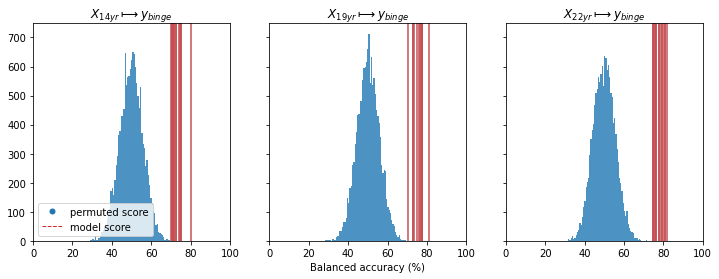

In [40]:
df = pd.read_csv("MLpipelines/results/holdout_all-tp-clean_run.csv")  

x='holdout_score'
no_confs=True
sorty_by=x
join=False

tp_map = {"bl":"14yr", "fu1":"16yr", "fu2":"19yr", "fu3":"22yr"} 
df["i_type"] = df["tp"].map(tp_map)
input_types_cnt = 3 
      
# select only the requested model 
df = df[df['model'].isin(BEST_MODELS)]
# hack: set all models as one
df["model"]= "model"

# calculate p_values if permutation tests were run
if f"permuted_{x}" in df.columns:
    df = calc_p_values(df, x, viz=True)
    
plt.savefig("figures/results_infer_pvals.pdf", bbox_inches='tight', pad_inches=0.05)

#### Other: Cross-site generalization

In [1]:
r_path = "lbls"
HOLDOUT_RESULTS = "MLpipelines/results/holdout_results_sites.csv"
OUTPUT = "results_sites"
df_fulls = [
    (r"(a) $X=$ sMRI features at age 22 (FU3)", [pd.read_csv(f) for f in sorted(glob(f"MLpipelines/results/across_sites/{r_path}-fu3*/*/run.csv"))]),
    (r"(b) $X=$ sMRI features at age 19 (FU2)", [pd.read_csv(f) for f in sorted(glob(f"MLpipelines/results/across_sites/{r_path}-fu2*/*/run.csv"))]),
    (r"(c) $X=$ sMRI features at age 14 (BL)",  [pd.read_csv(f) for f in sorted(glob(f"MLpipelines/results/across_sites/{r_path}-bl*/*/run.csv"))]),
]
x = "test_score"#'roc_auc'
conf_ctrl = 'cb'
sorty_by = None #'n_samples'
join = False
n_ios = 10
xlim = [0, 100]
# setup the figure properties
sns.set(style='whitegrid', context='paper')

fig, axes = plt.subplots(2, 1, dpi=120, sharex=True,
                         gridspec_kw={'height_ratios': [4, 1]},
                         figsize=(4.5, (1+0.5*(n_ios))))
explore_ax, infer_ax = axes

df = pd.DataFrame()

ax = axes[0]

# HACK : set the input_sMRI_type as a 'technique' to make the rest of the function work
for t, df_full in df_fulls:
    dfi = pd.concat(df_full)
    # drop confound-related columns
    dfi = dfi[~(dfi.i_is_conf) & ~(dfi.o_is_conf)]
    dfi = dfi[dfi["technique"]==conf_ctrl]
    # calculate p_values if permutation tests were run
    if f"permuted_{x}" in dfi.columns:
        dfi = calc_p_values(dfi, x)
    dfi["technique"] = t
    df = pd.concat([df, dfi])

# hacks
xlabel = "AUC ROC (%)" if (x=="roc_auc") else "Balanced accuracy (%)"
df.loc[df["o"]=="onset<15", "o"]="Onset"
df[x] = df[x]*100

# if the x metric is not in the results, then try to compute this metric from sklearn.metrics
if x not in df.columns:
    df = compute_metric(df, x)
    
y="o"     
y_order = ['Frequency','Amount',  'Onset',  'Binge', 'Binge_growth', 
           'AUDIT', 'AUDIT_quick', 'AUDIT_growth', 'Combined_seo', 'Combined_ours']#get_y_order(df, y=y, sorty_by=sorty_by)

palette = sns.color_palette()
dodge, scale, errwidth, capsize = 0.4, 0.4, 0.9, 0.08     
hue_order = ["LR", "SVM-lin", "SVM-rbf", "GB"]

for j, (t, dfi) in enumerate(df.groupby("technique", sort=False)):   
    ax = sns.pointplot(y=y, x=x, order=y_order,
                       hue="model", hue_order=hue_order,
                       join=join, data=dfi, ax=ax, 
                       ci='sd', errwidth=errwidth, capsize=0,
                       dodge=dodge, scale=scale, palette=palette)

ax.set_title("Exploratory analysis", fontsize=12)
ax.set_xlim(xlim)
ax.set_xlabel("")
ax.set_ylabel(r"$y=$ AAM phenotypes")

handles, legends = ax.get_legend_handles_labels()
leg1 = ax.legend(handles[:len(hue_order)], legends[:len(hue_order)], loc="upper right", title="ML models")

color='gray'
ax.axvline(x=50, label='chance', c='gray', ls='--', lw=1.5, alpha=0.7)
insigificance_interval = (32,70) if x=='roc_auc' else (35,65)
for xi in range(*insigificance_interval,2): 
    ax.axvline(x=xi, c=color, ls=':', lw=1.5, alpha=1, label='non-significant\ninterval')
    
handles, legends = ax.get_legend_handles_labels()
leg2 = ax.legend([handles[1]], [legends[1]], loc='upper left', fontsize=8)
ax.add_artist(leg1)

#######################################################################################

df = pd.read_csv(HOLDOUT_RESULTS)  
x='holdout_score'
no_confs=True
sorty_by=None
join=False
y="io" 
palette = sns.color_palette()[2:]

tp_map = {"bl":"14yr", "fu1":"16yr", "fu2":"19yr", "fu3":"22yr"} 
df["i_type"] = df["tp"].map(tp_map)
input_types_cnt = 3 

# select only the requested model 
df = df[df['model'].isin(BEST_MODELS)]

# calculate p_values if permutation tests were run
if f"permuted_{x}" in df.columns:
    df = calc_p_values(df, x, viz=False)
    
ios = df["io"].unique() 

# if the x metric is not in the results, then try to compute this metric from sklearn.metrics
if x not in df.columns:
    df = compute_metric(df, x)

# make io labels readable with latex formating
df.loc[:,"io"] = df.apply(remap_io, axis=1) 

df[x] = df[x]*100  
plt.xlim([0,100])  

y_order = df[y].unique()[::-1]

ax = sns.barplot(x=x, y=y, data=df, order=y_order, 
                 hue='model', hue_order=BEST_MODELS,
                 palette=palette)

# draw the chance line in the legend
ax.axvline(x=50, c='gray', ls='--', lw=1.5)

labelmodel_order = np.dstack(np.meshgrid(BEST_MODELS, y_order)).reshape(-1,2).tolist()
# perform FDR correction
from statsmodels.stats.multitest import multipletests
p_vals = [df.loc[(df[y]==yi) & (df['model']==mi), "p_value"].unique()[0] for mi,yi in labelmodel_order]
# print("\nbefore correction:\n", p_vals)
_,p_vals,_,_ = multipletests(p_vals, method="fdr_bh")
# print("after correction:\n", p_vals)
# add significance stars
for k, (mi,yi) in enumerate(labelmodel_order):
    ast = return_asterisks(p_vals[k])
    x_pos = df.loc[(df[y]==yi) & (df['model']==mi), x].mean() + 4 # + 4 offset
    y_pos = (k//2 - 0.05) + [-0.1,+0.25][BEST_MODELS.index(mi)]
#     print(mean_x, yi.split(' ')[0], 'xy=',(x_pos, y_pos), mi, "{:.4f}".format(p_vals[k]))
    ax.annotate(ast, xy=(x_pos, y_pos), 
                color='k', fontsize=8)

        
handles, legends = ax.get_legend_handles_labels()
ax.legend(handles[:2], legends[:2], fancybox=True, frameon=True, loc="upper right", fontsize=8)
ax.set_title("Generalization test", fontsize=13)
ax.set_ylabel("Analysis", labelpad=13)
plt.suptitle("Leave-one-site-out experiment")
plt.xlabel(xlabel)
plt.tight_layout()
plt.savefig("figures/{}{}.pdf".format(OUTPUT, "_auc" if x=='roc_auc' else ''), bbox_inches='tight', pad_inches=0.05)

NameError: name 'glob' is not defined

#### Other visualizations and stats

In [1]:
lbl_combinations = [  
    ("ESPAD_FU3",        '19a',        3, 6,   'Binge'),
    ("ESPAD_GM_FINE",  'cluster',   2, 6,   'Binge_growth'),
    ("PHENOTYPE",      'Phenotype', 0, 2,   'Combined_seo'),
    ("OUR_COMBO",      'cluster', 0, 2,   'Combined_ours'),
    (f"AUDIT_FU3",     'audit_total', 4, 8,   'AUDIT'),
    (f"AUDIT_FU3",     'audit_freq', 3, 6,   'AUDIT_quick'),
    ("AUDIT_GM_FINE",  "cluster", [0,3], [2,5,6], 'AUDIT_growth'),
    ("ESPAD_FU3",      '29d', [16,17,18,19,20,21], [11,12,13,14],   'onset<15'),
    ("ESPAD_FU3", '8b', 4, 6, 'Frequency'),
    (f"AUDIT_FU3",   'audit2', 0, 2, 'Amount'),
]

import os, sys, inspect 
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)
from imagen_dataloader import *

final_df = pd.DataFrame(index=Imagen(exclude_holdout=False).df_out.index)

x_tp = "FU3" #, "FU2", "BL"
lbl_combos = lbl_combinations
name = ""
use_all_data=True
viz=0
feature_cols=".+"
confs=['sex','site']

for i, (csv, col, c0, c1, colname) in enumerate(lbl_combos):
    if use_all_data:
        d = Imagen(exclude_holdout=False)
    elif use_only_holdout:  
        d = Imagen()
        d.df = d.df_holdout
        d.df_out = pd.DataFrame(index=d.df_holdout.index)
    else:
        d = Imagen()         

    if qs_is_raw_csv[csv]:
        dfq = pd.read_csv(qs[csv], usecols=["User code", col], dtype={"User code":str})
        dfq["ID"] = dfq["User code"].str.replace("-C", "").replace("-I", "").astype(int)
        dfq = dfq.drop("User code", axis=1)
    else:
        dfq = pd.read_csv(qs[csv], usecols=["ID", col])

    d.load_label(dfq, col=col, viz=(viz>1), binarize=True, class0=c0, class1=c1, y_colname=colname)
    # from x.prepare_X() get the subject IDS to filter out the right subjects
    feature = pd.read_csv(join(d.DATA_DIR, f"IMAGEN_BIDS/sMRI-derivatives_{x_tp}.csv"), index_col="ID")
    # filter columns
    feature = feature.filter(regex=feature_cols)
    d.df_out = d.df_out.loc[feature.index] 

    d.df_out[d.all_labels[0]] = d.df_out[d.all_labels[0]].map({0:0, np.nan:1, 1:2})
#         print(csv, len(feature.index))
    final_df[d.all_labels[0]] = d.df_out[d.all_labels[0]]
    
    # also get the confounds: add sex and site confounds
    if i==0:
        final_df[confs] = d.df[x_tp][confs]
        # remap sex values
        final_df['sex'] = final_df['sex'].map({'M':'Male','F':'Female'})
        final_df['site'] = final_df['site'].apply(lambda x: x.title())
        
    if viz: 
        plt.show()


confs=['Sex','Site']
final_df = final_df.rename(columns={'onset<15':'Onset', 'sex':confs[0], 'site':confs[1]})
final_df = final_df.dropna()
final_df

,Binge,Sex,Site,Binge_growth,Combined_seo,Combined_ours,AUDIT,AUDIT_quick,AUDIT_growth,Onset,Frequency,Amount
ID,,,,,,,,,,,,
112288,2.0,Male,Paris,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0
215284,0.0,Female,Nottingham,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
240546,1.0,Male,Berlin,1.0,1.0,1.0,2.0,0.0,1.0,1.0,2.0,0.0
297685,2.0,Female,Nottingham,2.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0
308867,2.0,Male,Nottingham,2.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
99677574,0.0,Female,Berlin,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
99873252,2.0,Female,Berlin,2.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
99875982,0.0,Female,London,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


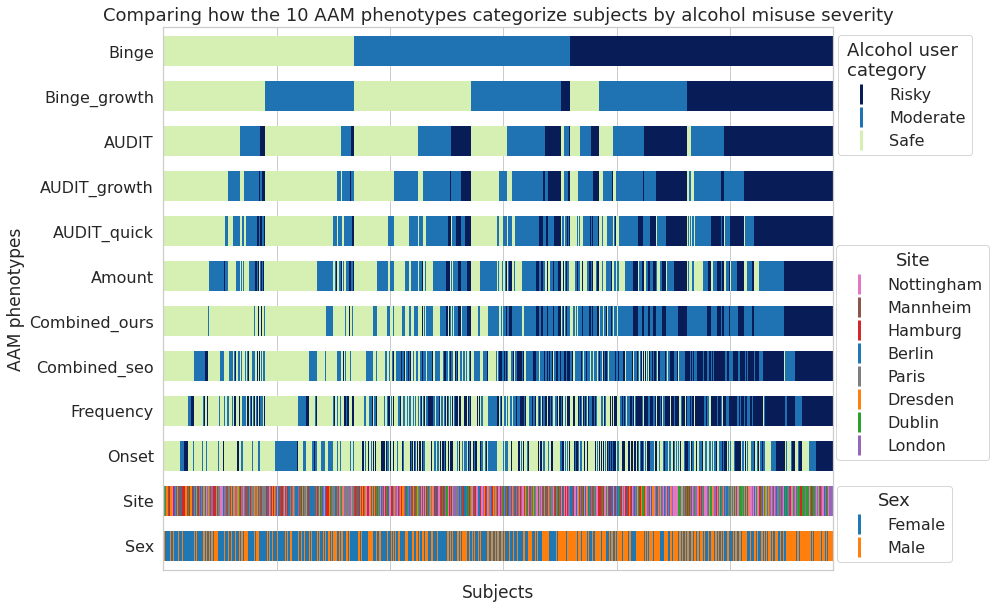

In [43]:
df_all_labels = load_all_labels()
CONFS = ['Sex', 'Site']

sort_order =  [n for n in sorted(df_all_labels.columns) if "binge" in n.lower()] + \
[n for n in sorted(df_all_labels.columns) if ("binge" not in n.lower()) and (n not in CONFS)] 
# sort_order = list(reversed(sort_order))
# print(sort_order)
fig, ax = plt.subplots(figsize=(12,len(sort_order)))

plot_subject_classes(df_all_labels, ax, confs=CONFS,
                     sort_order=sort_order, 
                     title="Comparing how the 10 AAM phenotypes categorize subjects by alcohol misuse severity",
                     lw=30, cmap=plt.cm.YlGnBu)
# plt.tight_layout(); plt.show()
plt.savefig('figures/AAM_lbls_compare.pdf', bbox_inches='tight', pad_inches=0, transparent=True)

In [11]:
# modalities = {
#               "":"all", 
#               "dti":"DTI", 
#               "t1w":"T1w", 
#               "area":"T1w:surf_area", "volume":"T1w:volume", "thickness":"T1w:thickness", "curv":"T1w:surf_curv"}
# dfs=[]
# input_types=[]

# for fil, name in modalities.items():
#     f = glob(f"MLpipelines/results/imaging_modalities/newlbls{fil}-*19a*/*/run.csv")
# #     print(f)
#     df = pd.read_csv(f[0])
#     # determine the input type for folder name
#     input_type = "{}".format(modalities[fil])
#     dfs.extend([df])
#     input_types.extend([input_type])

# ####
# df_full=dfs
# x="test_score"
# conf_ctrl=['cb']
# input_type=input_types
# no_confs=True
# sorty_by=None
# join=False
    
# input_types_cnt = 0
# if isinstance(df_full, (list, tuple)):
#     if isinstance(input_type, (list, tuple)) and len(input_type)==len(df_full):
#         df_full = [dfi.assign(i_type=i_type) for dfi, i_type in zip(df_full, input_type)]
#         input_types_cnt = len(input_type)
#     else:
#         df_full = [dfi.assign(i_type=input_type) for dfi in df_full]
#     df = pd.concat(df_full)
#     is_multi = True
# else:
#     df = df_full.copy()
#     df = df.assign(i_type=input_type)
#     is_multi = False
# # drop confound-related predictions if requested
# if "i_is_conf" in df.columns and no_confs: 
#     df = df[~(df.i_is_conf) & ~(df.o_is_conf)]

# # calculate p_values if permutation tests were run
# if f"permuted_{x}" in df.columns:
#     df = calc_p_values(df, x)

# # if conf_ctrl is not configured then automatically determine it
# if not conf_ctrl: 
#     conf_ctrl = df["technique"].unique()
# else:
#     df = df[df["technique"].isin(conf_ctrl)]

# ios = df["io"].unique() 
# # fixes
# xlabel = "AUC ROC (%)" if (x=="roc_auc") else "Balanced accuracy (%)"
# df.loc[:,"o"]== ""
# df[x] = df[x]*100

# # if the x metric is not in the results, then try to compute this metric from sklearn.metrics
# if x not in df.columns:
#     df = compute_metric(df, x)

# # make io labels readable with latex formating
# df.loc[:,"io"] = df.apply(remap_io, axis=1)     
# #   models_rename = {"LogisticRegression":"LR", "LinearSVC":"SVM-lin", "SVC":"SVM-rbf", "GradientBoostingClassifier":"GB"} # todo remove this backward compatibility code
# #     df = df.assign(model=lambda d: d.model.map(models_rename))    

# # setup the figure properties
# sns.set(style='whitegrid', context='paper')
# fig, axes = plt.subplots(1, len(conf_ctrl), 
#                          sharex=True, sharey=True, 
#                          dpi=120, figsize=(5*len(conf_ctrl), 1+0.4*(len(ios)+input_types_cnt)))
# if not isinstance(axes, np.ndarray): axes = [axes]
# plt.gca().set_xlim([0,100])    

# y="io"     
# y_order = get_y_order(df, y, sorty_by)

# for ((t, dfi), ax) in zip(df.groupby("technique"), axes):   

#     all_models = dfi["model"].unique()
#     # plotting details
#     palette = sns.color_palette()
#     ci, dodge, scale, errwidth, capsize = 95, 0.4, 0.4, 0.9, 0.08     
#     hue_order= [m for m in ["LR", "SVM-lin", "SVM-rbf", "GB"] if m in all_models]
#     # todo bugfix ci is sensible only if each trial score is statistically independant
#     ax = sns.pointplot(y=y, x=x, order=y_order,
#                        hue="model", hue_order=hue_order,
#                        join=join, data=dfi, ax=ax,
#                        ci=ci, errwidth=errwidth, capsize=capsize,
#                        dodge=dodge, scale=scale, palette=palette)
#     ax.legend_.remove()
#     ax.set_ylabel("")

#     # Add significance stars if permutation scores are available
#     if f"permuted_{x}" in dfi.columns:

#         # collect p_values as a dict of form {mean_accuracy: p_value}
#         p_dict = {g[x].mean(): g["p_value"].iloc[0] 
#                   for i, g in dfi.groupby(["io", "model"])}
#         # filter out the error bars from all lines 
#         # and store the position of their right edges to print the p_values at 
#         err_bars_pos = [(l.get_xdata()[1], l.get_ydata()[0])
#                         for l in ax.lines if l.get_ydata()[0]==l.get_ydata()[1]] 
#         # also collect the position of the mean 'accuracy' points
#         points_pos = [tuple(p_pos)  for c in ax.collections for p_pos in c.get_offsets()]

#         for i, pos in enumerate(err_bars_pos):

#             p_pos = points_pos[i]
#             # check that the y position of both the point and error bar are the same
#             assert p_pos[1] == pos[1], f"y position of mean pt ({p_pos}) and error bar ({pos}) don't match"
#             # choose the error bar with the same mean accuracy point
#             p =  p_dict[p_pos[0]] 
#             ast = return_asterisks(p)

#             ax.annotate(ast, np.array(pos) + (0.02, 0.06), 
#                         color=palette[i//len(df[y].unique())], fontsize=5)

#     # draw the chance line in the legend
#     chance = (len(dfi[y].unique()))*[50] #todo
#     for z, ch in enumerate(chance): 
#         ax.axvline(x=ch, ymin=z/len(chance), ymax=(z+1)/(len(chance)), 
#                     label="chance", c='gray', ls='--', lw=1.5)

# # add legend: add models info and chance label
# handles, legends = ax.get_legend_handles_labels()
# #only choose the first 'chance' legend
# handles = [handles[0]] + handles[len(chance):]
# legends = [legends[0]] + legends[len(chance):]
# plt.legend(handles, legends, loc="upper right", 
#            fancybox=True, frameon=True) 

# plt.axhline(0.5, color='gray', lw=0.5)
# plt.axhline(5.5, color='gray', lw=0.5)
# plt.title("Comparing input MRI features", fontsize=12)
# plt.xlabel(xlabel)
# plt.tight_layout()
# plt.savefig("figures/results_modality.pdf")

##### portion of binge drinkers at age 22 who were also binge drinkers at age 14 

In [722]:
import h5py as h5
f = h5.File('/ritter/share/data/IMAGEN/h5files/newlbls-bl-espad-fu3-19a-binge-n620.h5' ,'r')

df = pd.DataFrame(f[f.attrs['labels'][0]], index=list(f['i']), columns=f.attrs['labels'], dtype=int)
# df.info()

df["Binge"].value_counts()

1    334
0    286
Name: Binge, dtype: int64

In [720]:
from imagen_dataloader import qs
espad_BL = pd.read_csv(qs["ESPAD_BL"], sep=",", dtype={"User code":str, "Valid":str}, usecols=["User code", "19a"])
espad_BL["User code"] = espad_BL["User code"].apply(lambda x: int(x.replace("-C", "")))
espad_BL = espad_BL.rename(columns={"User code" : "ID"}).set_index("ID", drop=True)
# g.set_yticklabels([remapvalues_8x[int(float(t.get_text()))] for t in g.axes[0][0].get_yticklabels()])
# remapvalues_17x = {0:'0',1:'1',2:'2',3:'3-5',4:'6-9',5:'> 10', -1:"missing"}

df["Binge_age14"] = espad_BL["19a"]

df.value_counts().unstack()

Binge_age14,0.0,1.0,2.0,3.0,4.0,5.0,6.0
Binge,,,,,,,
0,178.0,21.0,4.0,3.0,1.0,NaN,1.0
1,154.0,67.0,18.0,12.0,10.0,4.0,NaN


In [1]:
(154.0 	+ 67.0 +	18.0 +	12.0 +	10.0 +	4.0)

265.0

<AxesSubplot:xlabel='Binge', ylabel='Binge_age14'>

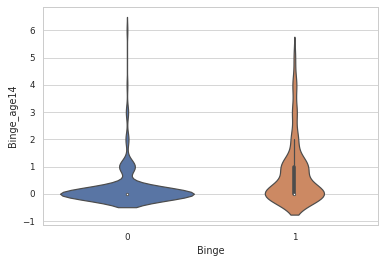

In [714]:
sns.violinplot(data=df, y="Binge_age14", x="Binge", split=False)

In [685]:
df.Binge.value_counts()

1.0    368
0.0    282
Name: Binge, dtype: int64